In [106]:
from self_supervised.pipelines.representation_model import RepresentationModel, YoloEncoder

%reload_kedro
model_description = catalog.load("yolov5_l_description")
trained_model = catalog.load("trained_model", version="2023-02-23T00.23.10.001Z")
#encoder = YoloEncoder(model_description=model_description)
#trained_model = RepresentationModel(encoder=encoder)
trained_model = trained_model.eval()

2023-02-28 14:20:47,761 - kedro.ipython - INFO - Resolved project path as: /home/daniel/git/self-supervised-learning.
To set a different path, run '%reload_kedro <project_root>'
2023-02-28 14:20:47,763 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.8/site-packages/kedro/framework/startup.py:98: DeprecationWarning: project_version in pyproject.toml is deprecated, use kedro_init_version instead
  warnings.warn(

2023-02-28 14:20:47,938 - kedro.ipython - INFO - Kedro project Self-Supervised Learning
2023-02-28 14:20:47,939 - kedro.ipython - INFO - Defined global variable 'context', 'session', 'catalog' and 'pipelines'
2023-02-28 14:20:47,944 - kedro.io.data_catalog - INFO - Loading data from 'yolov5_l_description' (YAMLDataSet)...
2023-02-28 14:20:47,950 - kedro.io.data_catalog - INFO - Loading data from 'trained_model' (PytorchModelDataSet)...


2023-02-28 14:20:47.950 | WARNING  | self_supervised.extras.datasets.pytorch_model_data_set:_load:42 - CUDA not available, automatically mapping variables to the CPU.


In [107]:
from pathlib import Path

dataset_path = Path("/home/daniel/lab_share/projects/CottonFlower2021/flower_dataset")
image_dir = dataset_path / "flower01" / "images"

In [108]:
from torchvision.io import read_image
from torchvision.transforms.functional import resize
from tqdm import tqdm
import torch

image_reps = []

image_list = sorted(list(image_dir.iterdir()))
for image_path in tqdm(image_list):
    image = read_image(image_path.as_posix())
    image.requires_grad = False
    image = resize(image, (512, 512))
    image = image.to(torch.float) / 255
    image_ex = image[None, :, :, :]
    
    image_reps.append(trained_model(image_ex)[0].detach().numpy())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 458/458 [01:06<00:00,  6.89it/s]


In [109]:
# Load flower counts.
import pandas as pd

labels_dir = dataset_path / "flower01" / "labels"
all_labels = []
labels_list = sorted(list(labels_dir.iterdir()))
for labels_path in labels_list:
    frame_labels = pd.read_csv(labels_path, sep=" ", names=["class", "x", "y", "width", "height"])
    frame_labels["frame"] = labels_path.name
    all_labels.append(frame_labels)
    
all_labels = pd.concat(all_labels, ignore_index=True)
all_labels

,class,x,y,width,height,frame
0,0,0.635938,0.238889,0.020833,0.037037,000001.txt
1,0,0.379427,0.065278,0.015104,0.034259,000001.txt
2,0,0.634375,0.245370,0.020833,0.037037,000002.txt
3,0,0.379948,0.068981,0.015104,0.034259,000002.txt
4,0,0.379948,0.069907,0.015104,0.034259,000003.txt
...,...,...,...,...,...,...
1987,0,0.495833,0.971759,0.030208,0.052778,000383.txt
1988,0,0.496875,0.976852,0.030208,0.046296,000384.txt
1989,0,0.497656,0.980093,0.028646,0.037963,000385.txt
1990,0,0.497135,0.986111,0.028646,0.027778,000386.txt


In [110]:
import numpy as np

# Create flower counts labels.
flower_counts = []
for image_path in labels_list:
    flower_counts.append(np.count_nonzero(all_labels["frame"] == image_path.name))

In [178]:
from sklearn.linear_model import Ridge

flower_counts = np.array(flower_counts, dtype=float)
image_reps_arr = np.concatenate(image_reps, axis=0)[:387]

reg = Ridge(alpha=0.0).fit(image_reps_arr, flower_counts)

In [138]:
test_image_dir = dataset_path / "flower02" / "images"

test_image_reps = []

image_list = sorted(list(test_image_dir.iterdir()))
for image_path in tqdm(image_list):
    image = read_image(image_path.as_posix())
    image.requires_grad = False
    image = resize(image, (512, 512))
    image = image.to(torch.float) / 255
    image_ex = image[None, :, :, :]
    
    test_image_reps.append(trained_model(image_ex)[0].detach().numpy())

test_image_reps = np.concatenate(test_image_reps, axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 333/333 [00:47<00:00,  6.99it/s]


In [179]:
test_preds = reg.predict(test_image_reps)
test_preds

array([    -2.4831,     -2.1934,     -2.0657,     -2.5024,      -1.938,     -2.6965,      -1.538,     -2.1571,     -1.5976,     -1.2941,     -1.7573,     -1.5054,     -2.2616,     -2.7875,     -1.8847,     -1.2749,    -0.87608,     0.28571,     0.11819,    0.099052,    -0.48085,    -0.29381,    -0.66149,     -1.0891,
            0.5182,      1.5757,      1.3028,      2.5069,      2.7178,      2.8326,      2.3228,      2.2878,      2.7142,      1.3671,       2.395,      1.7126,      2.8289,      3.7205,      4.2072,      3.7813,      3.2524,      3.1899,      3.4761,      4.1692,      4.2121,      3.3975,       4.074,      4.6567,
            5.0211,      4.9922,      4.8022,      5.1558,       4.211,       5.136,      6.8321,      7.7943,      7.3939,      7.0154,      7.7089,      8.1706,      8.4059,      9.7485,      9.7794,      8.7727,      8.6207,       9.321,      9.7748,      10.233,      6.5245,      7.4919,      6.2563,       8.027,
             6.331,      6.7641,      6.3113,      6.6072,       7.854,      8.0918,      8.0376,      9.4721,      9.9125,      9.0368,      9.6794,      9.0273,      8.5237,      8.1096,      8.8164,      6.4722,      6.6851,      5.3053,      5.5919,      5.8858,       6.838,      5.2661,      5.0332,      5.8875,
            4.9928,      5.3597,      5.7046,      5.3834,      6.8273,      8.2434,      5.8655,      5.8969,      6.5633,      7.3608,      7.0691,      6.5379,      5.2227,      5.6438,      5.5053,      5.1393,       4.469,      4.6052,      4.8908,      5.4548,      5.0062,      4.3988,      4.0183,      5.0556,
            6.7169,       6.601,      5.4646,      5.9257,      4.4814,      3.9153,      4.4767,      5.5615,      3.7926,      4.3513,      5.4944,      6.5015,      6.2767,      5.6288,      6.2332,      5.3938,       5.056,      4.6462,      3.7181,      4.1667,      5.1843,      5.6563,      5.7644,      4.7116,
            5.7427,      6.2795,      5.2465,      5.1214,      5.4913,       4.462,      4.9848,       5.008,      5.2419,        6.75,      7.0401,      6.5796,      5.6983,      5.7034,      6.2438,      6.2369,      6.5356,      7.7542,       6.756,      7.4895,      8.6775,      6.6637,      7.3058,      6.3084,
            7.4172,       8.246,      8.5606,      7.9046,      8.7376,      7.4027,      9.4118,      8.5429,      9.3106,      6.4942,      8.0959,      7.4648,      9.5435,      7.8509,      7.9301,      8.4841,      10.052,      9.0643,      9.0663,      8.8497,      8.1917,      8.0124,      10.244,      11.721,
            10.676,      11.675,      10.755,      11.125,       11.41,      8.5497,      8.7545,      10.339,      10.615,      9.9031,       10.28,      9.8273,      10.882,      11.068,      8.4472,      7.1621,      6.6307,       6.818,      8.8335,      9.6649,      9.6228,      10.365,      10.391,      9.7196,
            10.344,      11.125,      10.859,      9.2424,      11.765,      11.194,      10.568,      10.558,      9.5558,      10.012,      10.989,      9.8753,      10.889,      9.6224,      8.7011,       8.932,      7.8177,      7.8068,      9.1628,      7.8426,      5.4757,      4.9722,      5.8472,      5.7481,
            4.0345,      6.0724,      4.3955,        4.78,      4.7108,      6.5084,       5.327,      6.8048,      6.5597,      4.0661,      4.4289,      5.0454,      4.5314,      4.7796,      4.9207,      5.0321,      4.7855,      5.6501,       4.478,      3.4618,      3.0123,      3.5015,      2.3585,      3.4612,
            3.5568,      3.4228,      3.7989,      4.6775,      5.9742,      5.6056,      1.7587,      3.9029,      3.6243,      3.6194,      3.9278,      4.2022,      2.9368,      4.9979,       2.703,      1.4817,      1.2208,      2.0094,      1.0166,      1.4441,      4.0361,      4.2032,      5.1119,      5.3415,
              5.99,      2.6625,      3.4475,      2.1277,      1.8049,      2.9368,      2.2673,     0.35088,      1.1393,     0.65226,    -0.25501,    -0.43439,    -0.863

In [180]:
test_labels_dir = dataset_path / "flower02" / "labels"
all_labels_test = []
labels_list = sorted(list(test_labels_dir.iterdir()))
for labels_path in labels_list:
    frame_labels = pd.read_csv(labels_path, sep=" ", names=["class", "x", "y", "width", "height"])
    frame_labels["frame"] = labels_path.name
    all_labels_test.append(frame_labels)
    
all_labels_test = pd.concat(all_labels_test, ignore_index=True)
all_labels_test

,class,x,y,width,height,frame
0,0,0.407813,0.032870,0.014583,0.023148,000001.txt
1,0,0.408854,0.042130,0.014583,0.023148,000002.txt
2,0,0.408854,0.042130,0.014583,0.023148,000003.txt
3,0,0.408854,0.042130,0.014583,0.023148,000004.txt
4,0,0.408854,0.042130,0.014583,0.023148,000005.txt
...,...,...,...,...,...,...
1583,0,0.441406,0.814352,0.020313,0.036111,000287.txt
1584,0,0.437240,0.838426,0.020313,0.036111,000288.txt
1585,0,0.433073,0.858796,0.020313,0.036111,000289.txt
1586,0,0.434635,0.871759,0.011979,0.028704,000290.txt


In [181]:
# Create flower counts.
test_flower_counts = []
for image_path in labels_list:
    test_flower_counts.append(np.count_nonzero(all_labels_test["frame"] == image_path.name))
test_flower_counts = np.array(test_flower_counts, dtype=float)

In [182]:
np.mean(np.abs(test_preds[:291] - test_flower_counts))

1.851853531250839

2023-02-28 14:34:27,378 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.8/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":

2023-02-28 14:34:27,379 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.8/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)



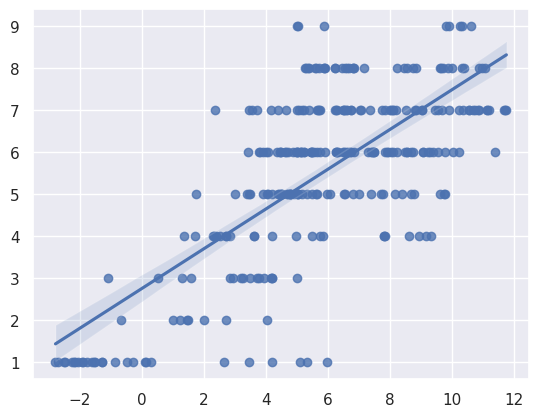

In [183]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

sns.regplot(x=test_preds[:291], y=test_flower_counts)
plt.show()